<a href="https://colab.research.google.com/github/gyuholee94/NLP/blob/master/FastText_naver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
#명령어
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
vocab_size = 47228
embedding_dim = 300
max_length = 71
truct_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
import pickle
with open('news_train_data.pickle', 'rb') as f: #불러오기
      train_data = pickle.load(f)
        
with open('news_test_data.pickle', 'rb') as f: #불러오기
      test_data = pickle.load(f)

In [ ]:
data = train_data['train_words_all']

In [ ]:
from gensim.models import FastText

Fast_naver = FastText(data, 
                 size=300, 
                 window=5, 
                 min_count=10, 
                 alpha=0.025, 
                 sg=1, 
                 iter=200
                   )

In [ ]:
Fast_naver

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index

In [ ]:
Fasttext_naver = list(word_index.keys())
Fasttext_naver[-1]

'수간'

In [ ]:
Fasttext_naver_1= Fast_naver.wv.__getitem__(Fasttext_naver)
Fasttext_naver_1.shape

(47228, 300)

In [ ]:
training_sequences  = tokenizer.texts_to_sequences(data)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

testing_sequences  = tokenizer.texts_to_sequences(test_data['test_words_all'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(train_data['label'])

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_data['label'])

In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[Fasttext_naver_1],
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)

In [ ]:
from tensorflow.keras import regularizers
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = Conv1D(128, fsz, activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.003))(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 300)      14168400    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 71, 128)      115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 71, 128)      153728      embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
4569/4569 - 381s - loss: 0.5913 - accuracy: 0.6788 - val_loss: 0.5940 - val_accuracy: 0.6761
Epoch 2/30
4569/4569 - 379s - loss: 0.5911 - accuracy: 0.6787 - val_loss: 0.5924 - val_accuracy: 0.6723
Epoch 3/30
4569/4569 - 379s - loss: 0.5898 - accuracy: 0.6783 - val_loss: 0.5957 - val_accuracy: 0.6716
Epoch 4/30
4569/4569 - 374s - loss: 0.5904 - accuracy: 0.6773 - val_loss: 0.5932 - val_accuracy: 0.6755
Epoch 5/30
4569/4569 - 374s - loss: 0.5902 - accuracy: 0.6783 - val_loss: 0.5976 - val_accuracy: 0.6714
Epoch 6/30
4569/4569 - 377s - loss: 0.5893 - accuracy: 0.6787 - val_loss: 0.5939 - val_accuracy: 0.6741
Epoch 7/30
4569/4569 - 385s - loss: 0.5887 - accuracy: 0.6789 - val_loss: 0.5931 - val_accuracy: 0.6738
Epoch 8/30
4569/4569 - 371s - loss: 0.5893 - accuracy: 0.6773 - val_loss: 0.5939 - val_accuracy: 0.6719
Epoch 9/30
4569/4569 - 372s - loss: 0.5893 - accuracy: 0.6775 - val_loss: 0.5992 - val_accuracy: 0.6690
Epoch 10/30
4569/4569 - 372s - loss: 0.5884 - accuracy: 0.6801 -

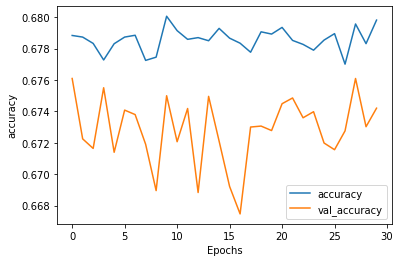

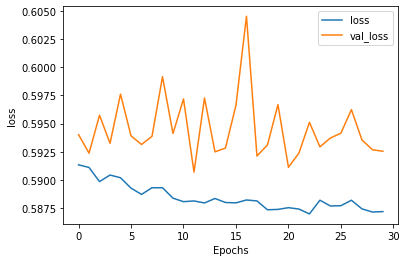

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') # 학습된 모델 저장

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
new_model